In [1]:
!pip install langchain langchain_core langchain_groq langchain_community langchain langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.2/412.2 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.3/145.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: langchain_core
    Found existing installation: langchain-core 0.3.29
    Uninstalling langchain-core-0.3.29:
      Successfully uninstalled langchain-core-0.3.29
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.14
    Uninstalling langchain-0.3.14:
      Successfully uninstalled langchain-0.3.14


In [5]:
import os
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

In [15]:
class PlannerState(TypedDict):
  messages: Annotated[List[HumanMessage | AIMessage], "the maessage in the conversation"]
  country: str
  city: str
  interests: List[str]
  itinearary : str

In [16]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    temperature = 0,
    groq_api_key= "gsk_RHCBRhSWlS8yru657tbxo1jSimWGdyb3FYlVgf14l1wuLFEpkF7wrmtm5K",
    model_name = "llama-3.3-70b-versatile"
)

In [17]:
result= llm.invoke("what are the advantage of doning Fazar salah")
result.content

'Fajr Salah, also known as Fazar Salah, is the dawn prayer in Islam, and it has numerous advantages and benefits. Here are some of the advantages of performing Fajr Salah:\n\n1. **Reward and Blessings**: Fajr Salah is considered one of the most rewarding prayers in Islam. The Prophet Muhammad (peace be upon him) said, "The two rak\'ahs of Fajr are better than the world and all that it contains." (Muslim)\n2. **Increased Faith and Spirituality**: Performing Fajr Salah helps to increase one\'s faith and spirituality. It sets a positive tone for the day and helps to establish a strong connection with Allah.\n3. **Improved Mental and Physical Health**: Waking up early for Fajr Salah has been shown to have numerous physical and mental health benefits, including improved cognitive function, increased energy, and a reduced risk of depression and anxiety.\n4. **Better Time Management**: Waking up early for Fajr Salah helps to establish a routine and discipline, which can translate to other are

In [18]:
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human", "Create an itinerary for my day trip."),
])

In [31]:
def input_city(state: PlannerState) -> PlannerState:
    print("Please enter the country you want to visit for your day trip: ")
    country_message = input("Your Input (Country): ")
    print("Please enter the city you want to visit for your day trip: ")
    city_message = input("Your Input (City): ")
    return {
        **state,
        "country": country_message,
        "city": city_message,
        "messages": state['messages'] + [HumanMessage(content=country_message), HumanMessage(content=city_message)]
    }

def input_interest(state: PlannerState) -> PlannerState:
    print(f"Please enter your interest for the trip to {state['city']} in {state['country']} (comma-separated): ")
    user_message = input("Your Input: ")
    return {
        **state,
        "interests": [interest.strip() for interest in user_message.split(",")],
        "messages": state['messages'] + [HumanMessage(content=user_message)]
    }

def create_itinerary(state: PlannerState) -> PlannerState:
    print(f"Creating an itinerary for {state['city']} in {state['country']} based on interests : {', '.join(state['interests'])}")
    response = llm.invoke(itinerary_prompt.format_messages(city = state['city'], country = state['country'], interests = ','.join(state['interests'])))
    print("\nFinal Itinerary: ")
    print(response.content)
    return {
        **state,
        "messages": state['messages'] + [AIMessage(content=response.content)],
        "itinerary" : response.content,
    }

In [32]:
workflow = StateGraph(PlannerState)

workflow.add_node("input_city", input_city)
workflow.add_node("input_interest", input_interest)
workflow.add_node("create_itinerary", create_itinerary)

workflow.set_entry_point("input_city")

workflow.add_edge("input_city", "input_interest")
workflow.add_edge("input_interest", "create_itinerary")
workflow.add_edge("create_itinerary", END)

app = workflow.compile()

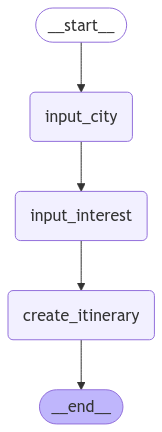

In [33]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method = MermaidDrawMethod.API
        )
    )
)

In [38]:
def travel_planner(user_request: str):
  print(f"Initial Request: {user_request}\n")
  state = {
      "messages": [HumanMessage(content=user_request)],
      "country": "",
      "city": "",
      "interests": [],
      "itinerary": "",
  }
  for output in app.stream(state):
    pass

In [39]:
user_request= "I want to plan a day trip"
travel_planner(user_request)

Initial Request: I want to plan a day trip

Please enter the country you want to visit for your day trip: 
Your Input (Country): Bnagladesh
Please enter the city you want to visit for your day trip: 
Your Input (City): Dhaka
Please enter your interest for the trip to Dhaka in Bnagladesh (comma-separated): 
Your Input: Dhaka
Creating an itinerary for Dhaka in Bnagladesh based on interests : Dhaka

Final Itinerary: 
For a day trip to Dhaka, here's a brief itinerary based on popular interests:

* 8:00 AM - 9:00 AM: Start the day with a visit to the Lalbagh Fort, a 17th-century Mughal fort and a great example of the city's rich history.
* 9:30 AM - 11:00 AM: Explore the Baitul Mukarram National Mosque, the 10th-largest mosque in the world and a prominent landmark in Dhaka.
* 11:30 AM - 1:00 PM: Visit the Bangladesh National Museum to learn about the country's history, culture, and art.
* 1:00 PM - 2:30 PM: Take a break for lunch at a local restaurant, trying some traditional Bangladeshi cu